### Avarage landmark movement emotion dataset comapared between different classes

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

#### Vizualization of avarage landmark movement for 6 classes

In [3]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
RAVDESS_PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/RAVDESS_processed_478_xyz_frontalized/')
metadata_path = os.path.join(RAVDESS_PROCESSED_DATA_DIR, 'train_processed_metadata.csv')

MAX_SAMPLES_PER_CLASS = 1
MAX_FRAMES = 33

TARGET_LABELS = [2, 3, 4, 5, 6, 8]
CENTER_POINT_INDEX = 2 # Środek nosa

EMOTION_MAP = {
    1: 'Neutralna',
    2: 'Spokojna',
    3: 'Szczęśliwa',
    4: 'Smutna',
    5: 'Zła',
    6: 'Przestraszona',
    7: 'Obrzydzenie',
    8: 'Zaskoczenie',
}

In [ ]:
def compute_central_distance(sequence_np, center_idx=CENTER_POINT_INDEX):
    """
    Oblicza normę L2 dystansu każdego punktu od centrum nosa (w tej samej klatce),
    a następnie uśrednia te dystanse po wszystkich punktach.
    Wymaga danych w formacie (T, 1434) [X1, Y1, Z1, X2, Y2, Z2, ...].
    """
    T, F = sequence_np.shape
    NUM_COORDS_PER_POINT = 3

    if F % NUM_COORDS_PER_POINT != 0:
        print(f"Błąd wymiaru: Oczekiwano liczby cech podzielnej przez 3. Znaleziono: {F}")
        return np.array([0.0] * T)

    N_points = F // NUM_COORDS_PER_POINT
    center_feature_indices = [center_idx * 3, center_idx * 3 + 1, center_idx * 3 + 2]
    center_coords_all_frames = sequence_np[:, center_feature_indices]
    points_to_process = sequence_np.reshape(T, N_points, NUM_COORDS_PER_POINT)
    center_repeated = center_coords_all_frames[:, np.newaxis, :]
    center_repeated = np.repeat(center_repeated, N_points, axis=1)
    difference = points_to_process - center_repeated
    euc_distance = np.linalg.norm(difference, axis=2)
    mean_dist = euc_distance.mean(axis=1)

    return mean_dist[:MAX_FRAMES]

In [ ]:
df = pd.read_csv(metadata_path)
df_filtered = df[df['label'].isin(TARGET_LABELS)]

data_by_label = {}

for label in TARGET_LABELS:
    subset = df_filtered[df_filtered['label'] == label]
    sequences = []

    for _, row in subset.head(MAX_SAMPLES_PER_CLASS).iterrows():
        npy_path_full = os.path.join(RAVDESS_PROCESSED_DATA_DIR, 'train', os.path.basename(row['npy_path']))

        if not os.path.exists(npy_path_full):
            print(f"❌ Ostrzeżenie: Nie znaleziono pliku: {npy_path_full}")
            continue

        sequence_np = np.load(npy_path_full).astype(np.float32)
        sequences.append(sequence_np)

    data_by_label[label] = sequences
    print(f"Załadowano {len(sequences)} sekwencji dla klasy {EMOTION_MAP.get(label, f'Nieznana ({label})')}")


Załadowano 1 sekwencji dla klasy Spokojna
Załadowano 1 sekwencji dla klasy Szczęśliwa
Załadowano 1 sekwencji dla klasy Smutna
Załadowano 1 sekwencji dla klasy Zła
Załadowano 1 sekwencji dla klasy Przestraszona
Załadowano 1 sekwencji dla klasy Zaskoczenie


In [ ]:
mean_distances = {}
min_len = MAX_FRAMES
all_curves = []

for label, sequences in data_by_label.items():
    if not sequences:
        continue

    # Używamy pierwszej (i jedynej) sekwencji
    seq = sequences[0]
    mean_dist = compute_central_distance(seq)

    all_curves.append((label, mean_dist))
    min_len = min(min_len, len(mean_dist))

if min_len == 0:
    print("Brak danych lub minimalna długość sekwencji wynosi 0. Analiza przerwana.")
    exit()

# Używamy min_len do wyrównania krzywych
for label, curve in all_curves:
    mean_distances[label] = curve[:min_len]

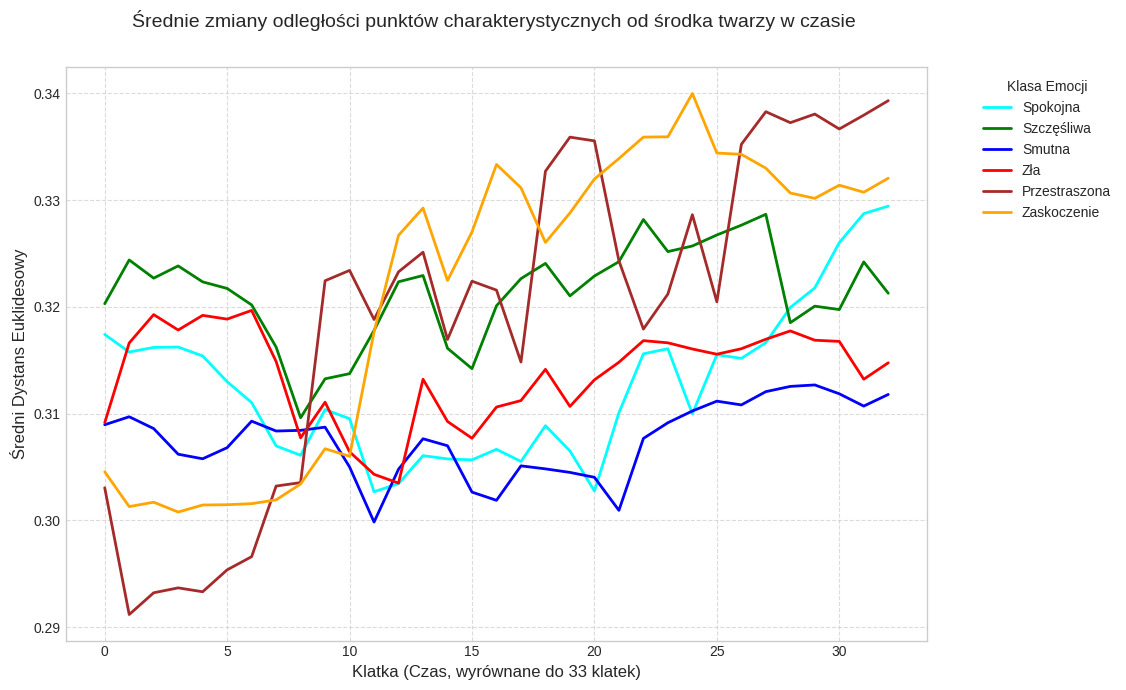

In [ ]:
plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-whitegrid')

# Definicja stylów i kolorów
plot_styles = {
    5: ('red', '-'),         # Zła
    1: ('gray', '-'),       # Neutralna
    4: ('blue', '-'),       # Smutna
    3: ('green', '-'),       # Szczęśliwa
    7: ('purple', '-'),      # Obrzydzenie
    8: ('orange', '-'),      # Zaskoczenie
    2: ('cyan', '-'),       # Spokojna
    6: ('brown', '-'),      # Przestraszona
}

for label, curve in mean_distances.items():
    emotion_name = EMOTION_MAP.get(label, f'Nieznana ({label})')
    color, linestyle = plot_styles.get(label, ('gray', ':'))

    plt.plot(curve,
             label=emotion_name,
             color=color,
             linestyle=linestyle,
             linewidth=2)

plt.xlabel(f"Klatka (Czas, wyrównane do {min_len} klatek)", fontsize=12)
plt.ylabel("Średni Dystans Euklidesowy", fontsize=12)
# Zgodnie z Pana opisem
plt.title(f"Średnie zmiany odległości punktów charakterystycznych od środka twarzy w czasie \n", fontsize=14, pad=15)
plt.legend(title="Klasa Emocji", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.show()


#### Visualization of landmarks selected from the three regions - lips, eyes and brows

In [4]:

REGION_INDICES = {
    'Usta': [61, 291, 0, 17, 13, 14, 37, 267, 78, 405, 314, 185, 80, 81, 82, 87, 178, 311, 402, 317, 318, 415, 375, 321, 375, 39, 95, 40, 181, 191, 146, 91, 84, 269, 270],
    'Brwi': [55, 65, 52, 53, 63, 105, 66, 107, 70, 285, 283, 295, 282, 293, 334, 296, 336, 300],
    'Oczy': [33, 7, 163, 144, 145, 154, 247, 263, 249, 390, 373, 374, 384, 398, 130, 155, 133, 173, 246, 362, 380, 382, 385, 386, 387, 388, 398, 466, 30, 29, 27, 28, 190, 414, 56, 258, 257, 259, 260, 467, 153, 286, 158, 159, 157, 161, 160],
}
CENTER_POINT_INDEX = 2

In [9]:
def visualize_landmarks_2d(npy_filepath, width=1920, height=1080):
    """
    Wczytuje pierwszą klatkę z pliku NPY i wizualizuje punkty w 2D (XY),
    uwzględniając proporcje obrazu (aspect ratio), aby uniknąć zniekształcenia twarzy.
    """
    try:
        sequence_np = np.load(npy_filepath).astype(np.float32)
    except FileNotFoundError:
        print(f"Błąd: Nie znaleziono pliku NPY: {npy_filepath}")
        return
    except Exception as e:
        print(f"Błąd wczytywania: {e}")
        return

    frame_0 = sequence_np[0, :]
    F_full = len(frame_0) # 1434

    if F_full % 3 != 0:
        print("Nieprawidłowy wymiar cech. Oczekiwano liczby podzielnej przez 3 (XYZ).")
        return

    N_points = F_full // 3 # 478
    points = frame_0.reshape(N_points, 3)

    # --- KOREKTA ASPECT RATIO ---
    # Obliczamy mnożnik dla osi X
    aspect_ratio = width / height

    # Skalujemy tylko X, Y pozostaje bazą (referencją 1:1)
    X = points[:, 0] * aspect_ratio
    Y = points[:, 1]

    fig, ax = plt.subplots(figsize=(10, 8)) # Zmiana proporcji okna na bardziej poziomą

    region_colors = {
        'Usta': 'red',
        'Brwi': 'blue',
        'Oczy': 'green',
        'Inne': 'lightgray',
        'Nos (Centrum)': 'black'
    }

    # Rysowanie tła (wszystkie punkty)
    ax.scatter(X, Y, c=region_colors['Inne'], label='Inne punkty', s=5, alpha=0.4)

    # Rysowanie wybranych regionów
    for region_name, indices in REGION_INDICES.items():
        indices_np = np.array(indices)
        valid_indices = indices_np[indices_np < N_points]

        X_reg = X[valid_indices]
        Y_reg = Y[valid_indices]

        ax.scatter(X_reg, Y_reg,
                   c=region_colors[region_name],
                   label=f'{region_name} ({len(valid_indices)} pkt)',
                   s=35,
                   marker='o',
                   edgecolors='black',
                   linewidths=0.3)

    # Zaznaczenie punktu centralnego (nos)
    if CENTER_POINT_INDEX < N_points:
        X_nos, Y_nos = X[CENTER_POINT_INDEX], Y[CENTER_POINT_INDEX]
        ax.scatter(X_nos, Y_nos,
                   c=region_colors['Nos (Centrum)'],
                   label='Nos (Centrum)',
                   s=150,
                   marker='X',
                   edgecolors='white',
                   zorder=5)

    # Ustawienia wykresu
    ax.set_title(f"Mapa punktów charakterystycznych", fontsize=14)
    ax.set_xlabel(f'X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)

    # Zachowanie proporcji 1:1 na monitorze (koło będzie kołem)
    ax.set_aspect('equal', adjustable='box')

    # Odwrócenie osi Y (konwencja obrazu)
    ax.invert_yaxis()

    # Dynamiczne ustawienie granic z małym marginesem
    margin = 0.05
    ax.set_xlim(X.min() - margin, X.max() + margin)
    ax.set_ylim(Y.max() + margin, Y.min() - margin)

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

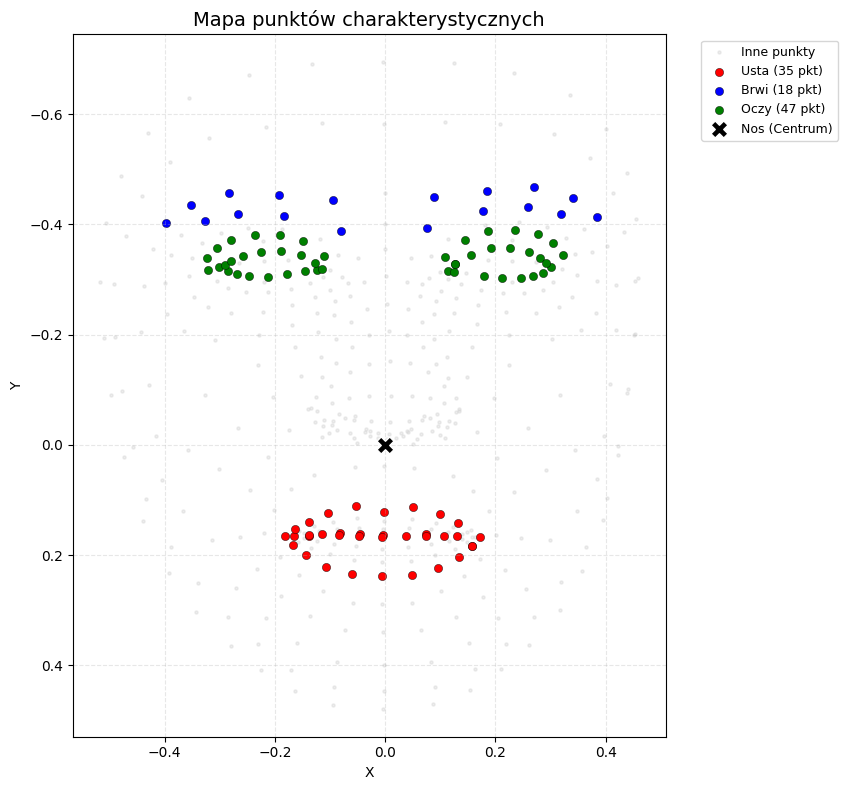

In [10]:
df_meta = pd.read_csv(metadata_path)

example_row = df_meta[df_meta['label'] == 4].iloc[0]
npy_filename = os.path.basename(example_row['npy_path'])
example_npy_path = os.path.join(RAVDESS_PROCESSED_DATA_DIR, 'train', npy_filename)

visualize_landmarks_2d(example_npy_path)


#### Visualization of the avarage landmark movement for 6 classes in each of the selected regions

In [ ]:
df = pd.read_csv(metadata_path)
df_filtered = df[df['label'].isin(TARGET_LABELS)]

data_by_label_raw = {}
for label in TARGET_LABELS:
    subset = df_filtered[df_filtered['label'] == label]
    sequences = []
    for _, row in subset.head(MAX_SAMPLES_PER_CLASS).iterrows():
        npy_path_full = os.path.join(RAVDESS_PROCESSED_DATA_DIR, 'train', os.path.basename(row['npy_path']))
        if os.path.exists(npy_path_full):
            sequences.append(np.load(npy_path_full).astype(np.float32))
    data_by_label_raw[label] = sequences
    print(f"Załadowano 1 sekwencję dla klasy {EMOTION_MAP.get(label)}")

Załadowano 1 sekwencję dla klasy Spokojna
Załadowano 1 sekwencję dla klasy Szczęśliwa
Załadowano 1 sekwencję dla klasy Smutna
Załadowano 1 sekwencję dla klasy Zła
Załadowano 1 sekwencję dla klasy Przestraszona
Załadowano 1 sekwencję dla klasy Zaskoczenie


In [ ]:
def compute_central_distance_regions(sequence_np, center_idx=CENTER_POINT_INDEX, selected_indices=None):
    T, F_full = sequence_np.shape
    NUM_COORDS_PER_POINT = 3

    # 1. Filtrowanie cech na podstawie wybranych indeksów punktów
    if selected_indices:
        # Przekształcenie indeksów punktów na indeksy cech (X, Y, Z)
        feature_indices_x = np.array(selected_indices) * NUM_COORDS_PER_POINT
        feature_indices_y = feature_indices_x + 1
        feature_indices_z = feature_indices_x + 2

        # Łączymy wszystkie cechy (X, Y, Z) dla wybranych punktów
        selected_feature_indices = np.concatenate([
            feature_indices_x,
            feature_indices_y,
            feature_indices_z
        ]).flatten()

        # Filtrowanie sekwencji
        sequence_to_process = sequence_np[:, selected_feature_indices]
        N_points = len(selected_indices)
    else:
        # Używamy wszystkich 478 punktów
        sequence_to_process = sequence_np
        N_points = F_full // NUM_COORDS_PER_POINT # 478

    # 2. Obliczenie indeksów XYZ punktu centralnego (NOS)
    center_feature_indices = [center_idx * 3, center_idx * 3 + 1, center_idx * 3 + 2]

    # 3. Pobranie współrzędnych centrum we wszystkich klatkach (Z PEŁNEJ SEKWENCJI)
    center_coords_all_frames = sequence_np[:, center_feature_indices]

    # 4. Zmiana kształtu i powielenie punktu centralnego
    points_to_process = sequence_to_process.reshape(T, N_points, NUM_COORDS_PER_POINT)
    center_repeated = center_coords_all_frames[:, np.newaxis, :]
    center_repeated = np.repeat(center_repeated, N_points, axis=1)

    # 5. Obliczenie różnicy i normy Euklidesowej (Dystans L2)
    difference = points_to_process - center_repeated
    euc_distance = np.linalg.norm(difference, axis=2)

    # 6. Uśrednienie dystansów po wszystkich wybranych punktach
    mean_dist = euc_distance.mean(axis=1)

    # 7. Ograniczenie do MAX_FRAMES
    return mean_dist[:MAX_FRAMES]

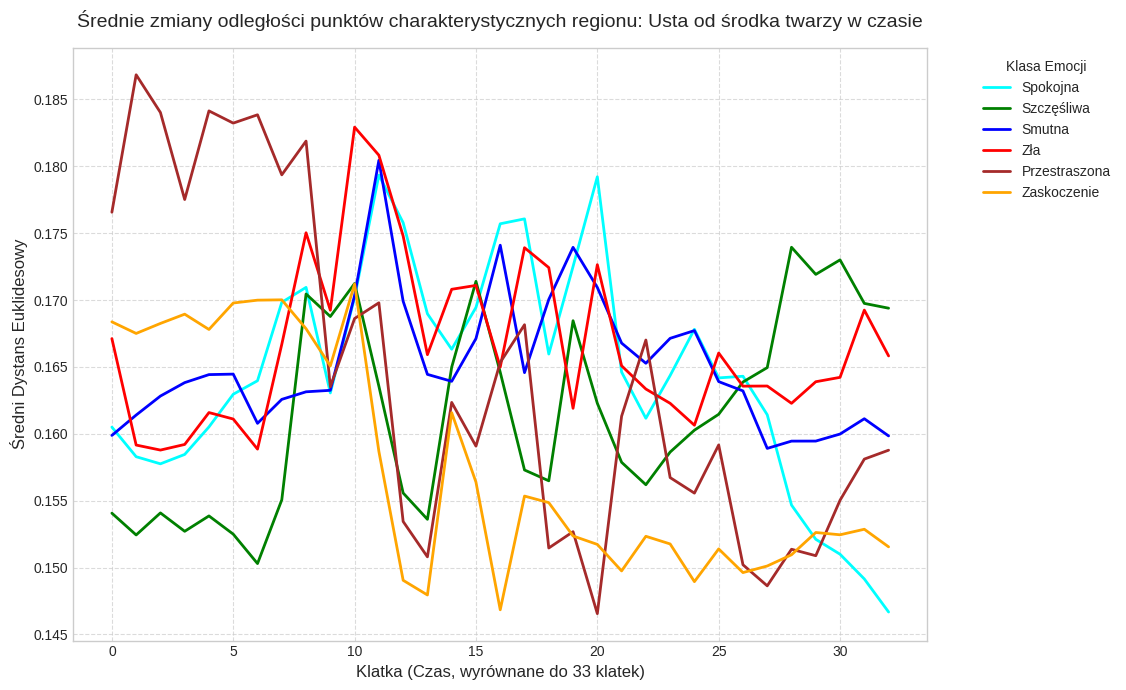

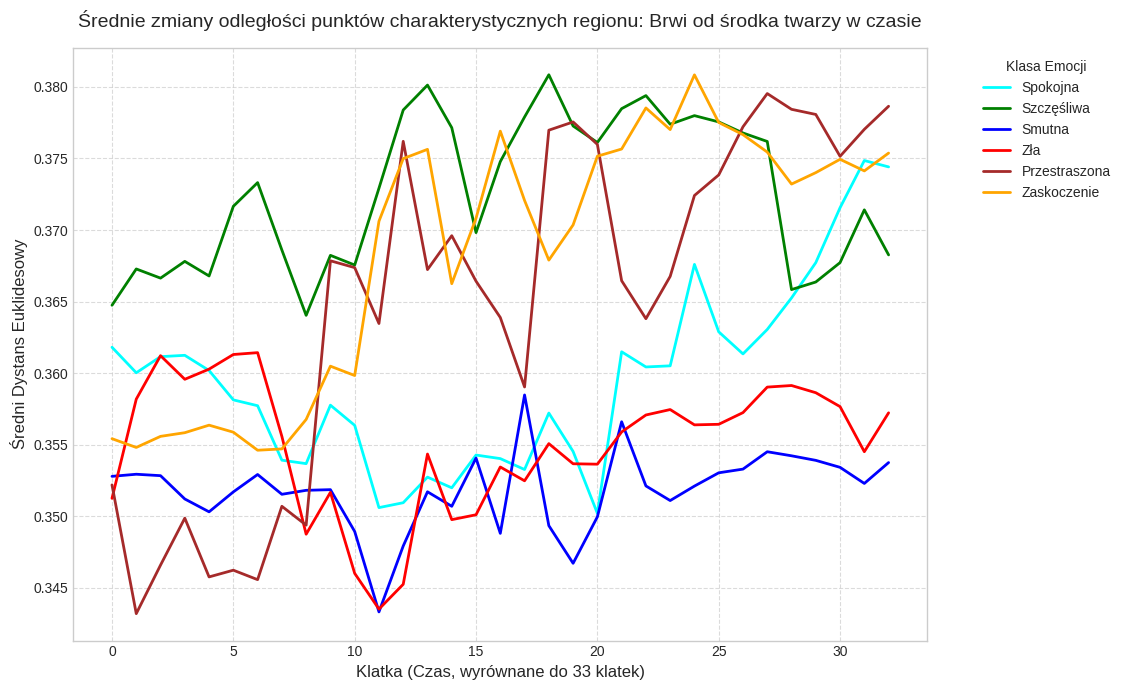

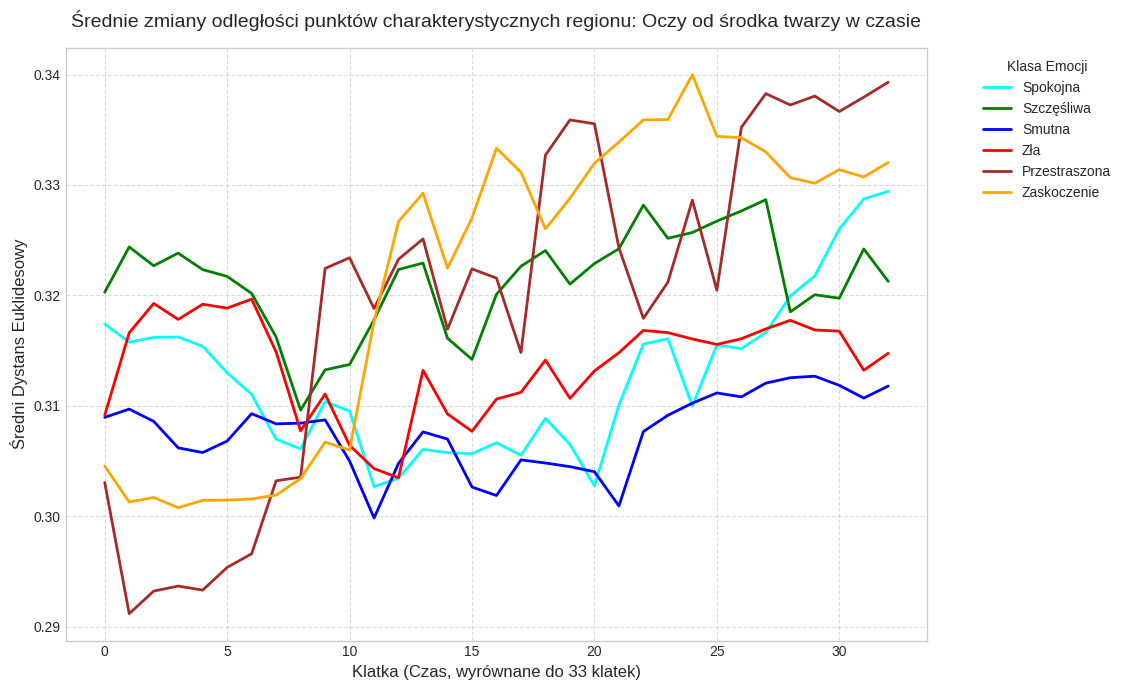

In [ ]:
plot_styles = {
    5: ('red', '-'),         # Zła
    1: ('gray', '-'),       # Neutralna
    4: ('blue', '-'),       # Smutna
    3: ('green', '-'),       # Szczęśliwa
    7: ('purple', '-'),      # Obrzydzenie
    8: ('orange', '-'),      # Zaskoczenie
    2: ('cyan', '-'),       # Spokojna
    6: ('brown', '-'),      # Przestraszona
}

for region_name, indices in REGION_INDICES.items():

    mean_distances = {}
    min_len = MAX_FRAMES

    # Oblicz dystanse dla każdego nagrania w danym regionie
    for label in TARGET_LABELS:
        sequences = data_by_label_raw.get(label, [])
        if not sequences:
            continue

        # Używamy compute_central_distance z filtrowaniem
        mean_dist = compute_central_distance_regions(sequences[0], selected_indices=indices)

        mean_distances[label] = mean_dist
        min_len = min(min_len, len(mean_dist))

    # Wyrównanie do minimalnej długości (min_len)
    for label in mean_distances:
        mean_distances[label] = mean_distances[label][:min_len]

    # WIZUALIZACJA
    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid')

    for label, curve in mean_distances.items():
        emotion_name = EMOTION_MAP.get(label, f'Nieznana ({label})')
        color, linestyle = plot_styles.get(label, ('gray', ':'))

        plt.plot(curve,
                 label=emotion_name,
                 color=color,
                 linestyle=linestyle,
                 linewidth=2)

    plt.xlabel(f"Klatka (Czas, wyrównane do {min_len} klatek)", fontsize=12)
    plt.ylabel("Średni Dystans Euklidesowy", fontsize=12)
    plt.title(f"Średnie zmiany odległości punktów charakterystycznych regionu: {region_name} od środka twarzy w czasie", fontsize=14, pad=15)
    plt.legend(title="Klasa Emocji", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.95, 1])

    plt.show()
